/var/folders/22/ml097ncs17v22rd4q1y1vm3r0000gn/T/ipykernel_89657/21935365.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)  # Fill categorical with mode
/var/folders/22/ml097ncs17v22rd4q1y1vm3r0000gn/T/ipykernel_89657/21935365.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which

SMOTE failed due to low sample size. Using Random Oversampling instead.
Epoch 1/50, Loss: -56.1740
Epoch 2/50, Loss: -935.1265
Epoch 3/50, Loss: -3795.4542
Epoch 4/50, Loss: -9310.7822
Epoch 5/50, Loss: -17882.2901
Epoch 6/50, Loss: -29767.1243
Epoch 7/50, Loss: -45193.7545
Epoch 8/50, Loss: -64425.3845
Epoch 9/50, Loss: -87674.9996
Epoch 10/50, Loss: -115097.1541
Epoch 11/50, Loss: -146980.5469
Epoch 12/50, Loss: -183554.7671
Epoch 13/50, Loss: -225206.3339
Epoch 14/50, Loss: -271964.5131
Epoch 15/50, Loss: -324265.5486
Epoch 16/50, Loss: -382082.4787
Epoch 17/50, Loss: -445954.7344
Epoch 18/50, Loss: -515708.4440
Epoch 19/50, Loss: -592257.1235
Epoch 20/50, Loss: -675160.3682
Epoch 21/50, Loss: -765233.1481
Epoch 22/50, Loss: -862325.3266
Epoch 23/50, Loss: -966674.1466
Epoch 24/50, Loss: -1078198.4982
Epoch 25/50, Loss: -1198334.4118
Epoch 26/50, Loss: -1325707.5059
Epoch 27/50, Loss: -1461852.5290
Epoch 28/50, Loss: -1606138.3618
Epoch 29/50, Loss: -1759916.1269
Epoch 30/50, Loss: 

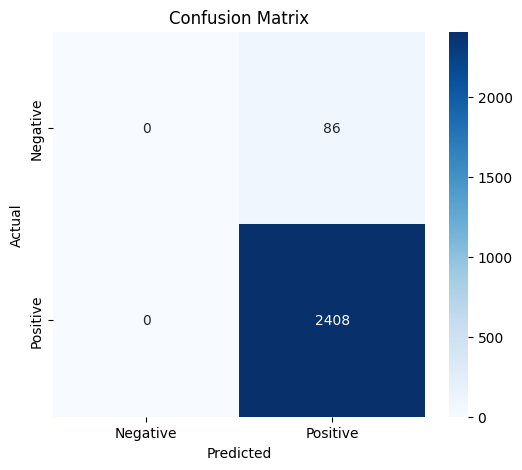

Test Loss: 77198778647380384.0000
Mean Absolute Error: 249207306.7811
R2 Score: -1103632376737316.1250
Accuracy: 0.9655
Precision: 0.9655
Recall: 1.0000
F1 Score: 0.9825


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE, RandomOverSampler

# Load the dataset
df = pd.read_csv("/Users/raghav/Documents/GitHub/ACSEF/newACSEFDataframe.csv")  # Change this to your actual file path

# Handle missing values
for col in df.columns:
    if df[col].dtype == 'object':
        df[col].fillna(df[col].mode()[0], inplace=True)  # Fill categorical with mode
    else:
        df[col].fillna(df[col].median(), inplace=True)  # Fill numerical with median

# Encode categorical variables
for col in df.select_dtypes(include=['object']).columns:
    df[col] = LabelEncoder().fit_transform(df[col])

# Define target and features
target_column = "MostVariableGene"
if target_column not in df.columns:
    raise ValueError(f"Target column '{target_column}' not found in the dataset.")

X = df.drop(columns=[target_column])
y = df[target_column]

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Handle class imbalance dynamically
try:
    smote = SMOTE(sampling_strategy='auto', k_neighbors=min(5, np.bincount(y)[1]-1), random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_scaled, y)
except ValueError:
    print("SMOTE failed due to low sample size. Using Random Oversampling instead.")
    ros = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = ros.fit_resample(X_scaled, y)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_resampled, dtype=torch.float32)
y_tensor = torch.tensor(y_resampled.values, dtype=torch.float32).view(-1, 1)

# Split dataset into train and test
train_size = int(0.8 * len(X_tensor))
test_size = len(X_tensor) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(TensorDataset(X_tensor, y_tensor), [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Define the neural network model
class NeuralNet(nn.Module):
    def __init__(self, input_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

# Initialize the model
input_size = X_resampled.shape[1]
model = NeuralNet(input_size)
class_counts = np.bincount(y_resampled)
class_weights = torch.tensor([1.0 / class_counts[0], 1.0 / class_counts[1]], dtype=torch.float32)
criterion = nn.BCEWithLogitsLoss(weight=class_weights[1])
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

# Evaluate the model
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        y_true.extend(targets.numpy())
        y_pred.extend(outputs.numpy())

# Convert predictions to binary classes if needed
y_pred_class = [1 if y > 0.5 else 0 for y in y_pred]
y_true_class = [1 if y > 0.5 else 0 for y in y_true]

# Compute evaluation metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
accuracy = accuracy_score(y_true_class, y_pred_class)
precision = precision_score(y_true_class, y_pred_class, zero_division=1)
recall = recall_score(y_true_class, y_pred_class)
f1 = f1_score(y_true_class, y_pred_class)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_class, y_pred_class)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print(f"Test Loss: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R2 Score: {r2:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
